## Histórico de unidades equivalentes 

In [1]:
from pydataxm import *                           #Se realiza la importación de las librerias necesarias para ejecutar                        
from pydataxm.pydataxm import ReadDB as apiXM 
import datetime as dt                            
import pandas as pd
from pathlib import Path
import os

from google.cloud import bigquery
from google.oauth2 import service_account

In [2]:
# Información del proyecto y autenticación a BQ
project_id = "enersinc-tbsg-bq"
key_path = "C:\BigQuery\eramirez-tbsg.json"

# Cargar las credenciales del archivo JSON
credentials = service_account.Credentials.from_service_account_file(key_path)

# Crear el cliente de BigQuery
client = bigquery.Client(project=project_id, credentials=credentials)

## Histórico de Caribe 2

In [3]:
FechaIni='2023-01-01'
FechaFin='2025-11-08'

In [4]:
# Consulta a la maestra de recursos
query = rf"""
select * from 
tbsg.public_dsegdes
where fechaoperacion >='{FechaIni}'and fechaoperacion <='{FechaFin}' and lower(nombre) like 'zs%car%2'
order by fechaoperacion
"""

# Ejecutar la consulta
df_UEIni = client.query(query).to_dataframe()

In [5]:
df_UE=df_UEIni.copy()

for i in range(1,25):
    df_UE = df_UE.rename(columns={f'hora{i}': i})

df_UE = df_UE.melt(id_vars=['fechaoperacion', 'nombre'], 
                       value_vars=[i for i in range(1, 25)], 
                       var_name='periodo', 
                       value_name='UE')

df_UE['year']=pd.to_datetime(df_UE['fechaoperacion']).dt.year
df_UE['Mes']=pd.to_datetime(df_UE['fechaoperacion']).dt.month


In [9]:
df_UE

,fechaoperacion,nombre,periodo,UE,year,Mes
0,2023-01-01,ZS_CARIBE2,1,2.5,2023,1
1,2023-01-02,ZS_CARIBE2,1,3.5,2023,1
2,2023-01-03,ZS_CARIBE2,1,4.0,2023,1
3,2023-01-04,ZS_CARIBE2,1,4.0,2023,1
4,2023-01-05,ZS_CARIBE2,1,4.0,2023,1
...,...,...,...,...,...,...
24955,2025-11-04,ZS_CARIBE2,24,6.5,2025,11
24956,2025-11-05,ZS_CARIBE2,24,6.5,2025,11
24957,2025-11-06,ZS_CARIBE2,24,7.0,2025,11
24958,2025-11-07,ZS_CARIBE2,24,6.5,2025,11


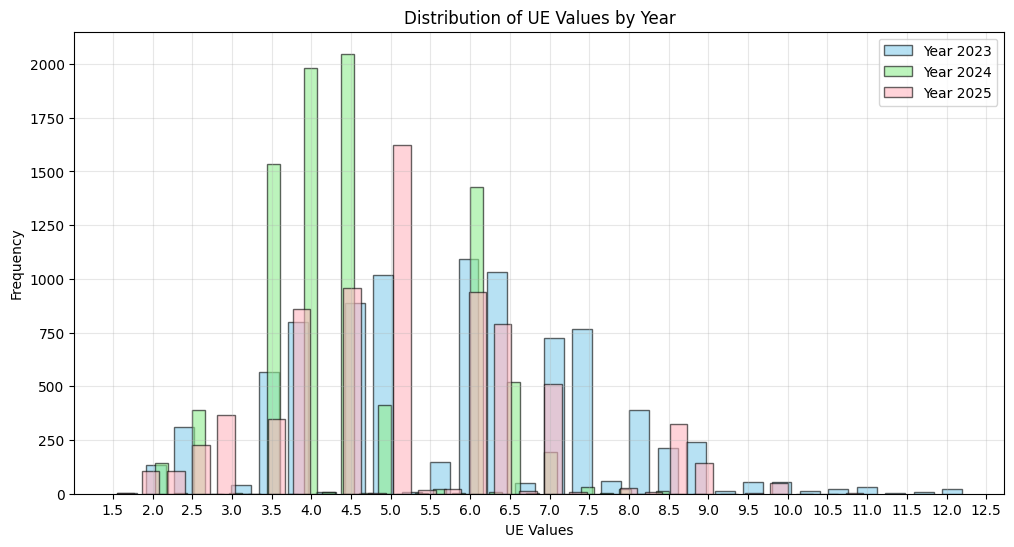

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 6))

colors = [
    (135/255, 206/255, 235/255, 0.6),  # soft blue
    (144/255, 238/255, 144/255, 0.6),  # soft green
    (255/255, 182/255, 193/255, 0.6),  # soft pink
]

# Obtener rango del eje X
xmin = df_UE['UE'].min()
xmax = df_UE['UE'].max()

for year, color in zip(sorted(df_UE['year'].unique()), colors):
    year_data = df_UE[df_UE['year'] == year]['UE']
    plt.hist(
        year_data,
        bins=30,
        alpha=0.6,
        label=f'Year {year}',
        color=color,
        edgecolor='black',
        rwidth=0.7  # <<< barras más delgadas
    )

# Configurar ticks de 0.5 en el eje X
plt.xticks(np.arange(round(xmin, 1), round(xmax + 0.5, 1), 0.5))

plt.title('Distribution of UE Values by Year')
plt.xlabel('UE Values')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()



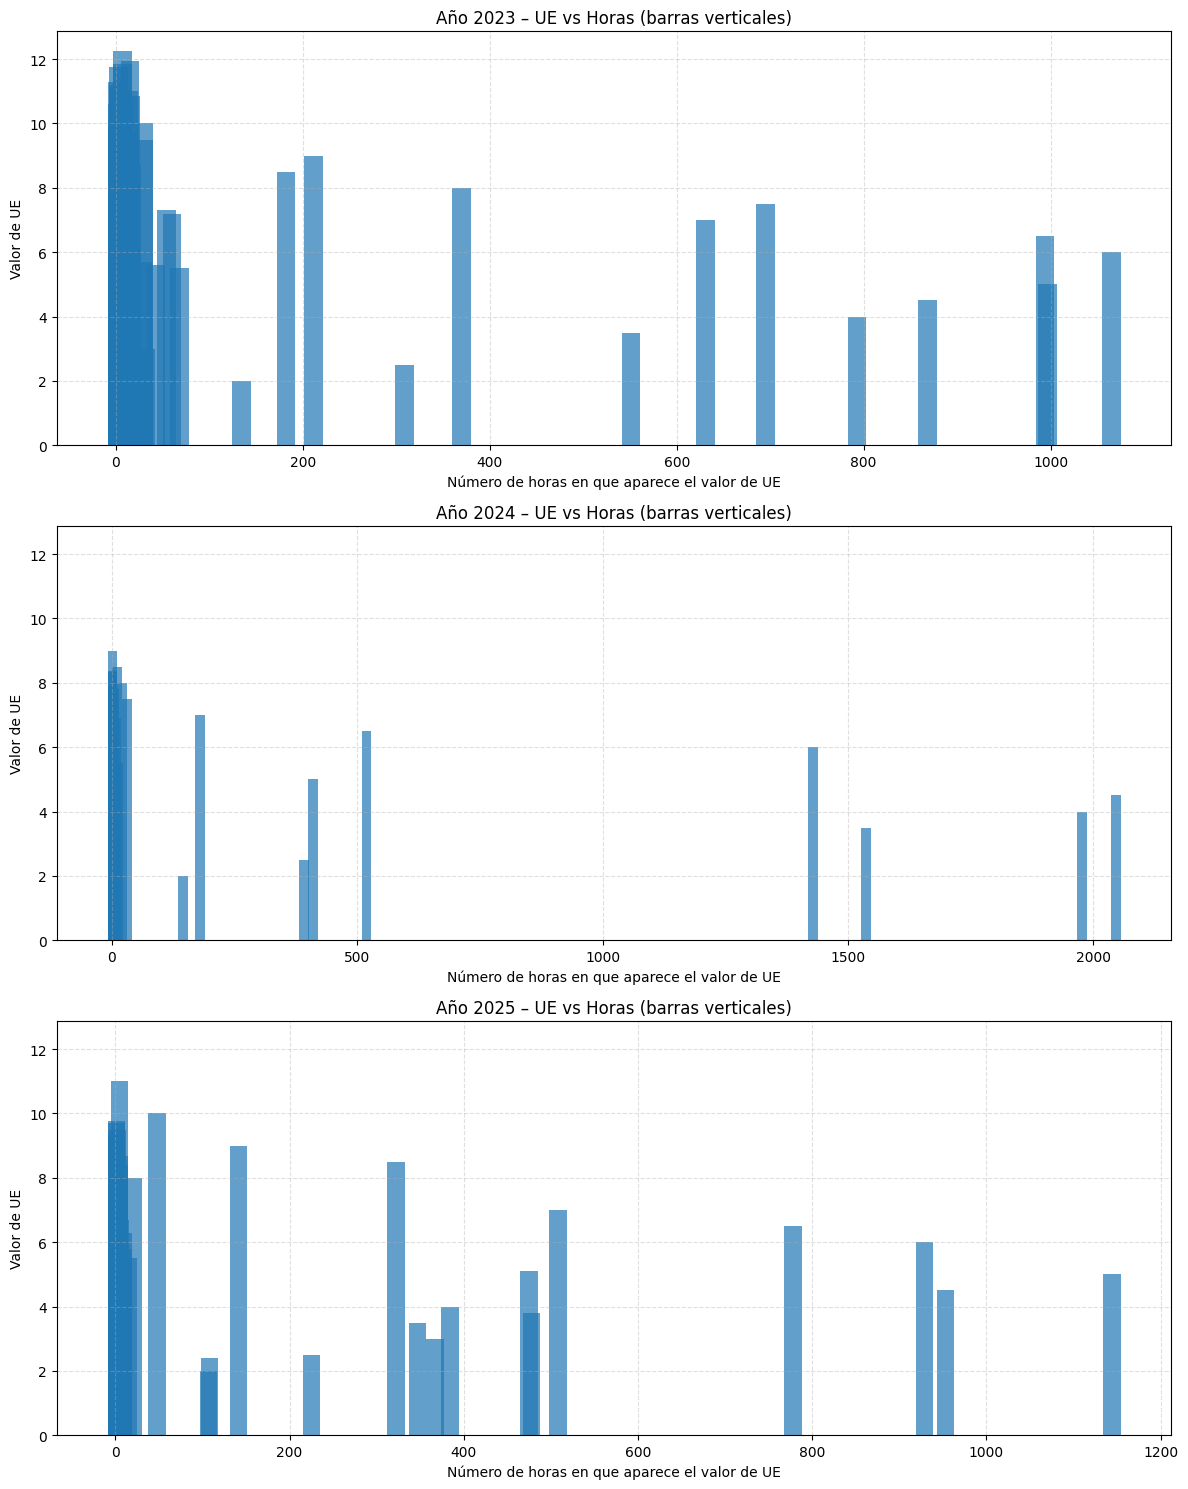

In [14]:
# =====================================================
# 1. Copia del dataframe
# =====================================================
df_UE_copy = df_UE.copy()

df_UE_copy['fechaoperacion'] = pd.to_datetime(df_UE_copy['fechaoperacion'])
df_UE_copy['year'] = df_UE_copy['fechaoperacion'].dt.year

# =====================================================
# 2. Contar cuántas horas aparece cada valor UE por año
# =====================================================
df_counts = (
    df_UE_copy.groupby(['year', 'UE'])
              .size()
              .reset_index(name='horas')
)


# =====================================================
# 3. Gráfico de barras VERTICALES (X = horas, Y = UE) por año
# =====================================================
import matplotlib.pyplot as plt

years = sorted(df_counts['year'].unique())

fig, axes = plt.subplots(len(years), 1, figsize=(12, 5*len(years)), sharey=True)

if len(years) == 1:
    axes = [axes]

for ax, yr in zip(axes, years):
    df_plot = df_counts[df_counts['year'] == yr].sort_values("horas")

    ax.bar(df_plot['horas'], df_plot['UE'], width=20, alpha=0.7)
    ax.set_title(f"Año {yr} – UE vs Horas (barras verticales)")
    ax.set_xlabel("Número de horas en que aparece el valor de UE")
    ax.set_ylabel("Valor de UE")
    ax.grid(True, linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()



## Histórico de unidades equivalentes de Bolivar

In [13]:
# Función para asignar los días de la semana a cada fecha, si es festivo se trata como un domingo
import holidays
co_holidays = holidays.Colombia()

def typedays(row,tipo):

     if tipo=='WeekDay':
          return row['fecha'].weekday()
     
     elif tipo=='WeekMonth':
          return (row['fecha'].day - 1) // 7 + 1
     
     elif tipo=='DayType':
          if row['fecha'] in co_holidays:
               return 'F'
          elif row['fecha'].weekday()==5:
               return 'S'
          elif row['fecha'].weekday()==6:
               return 'F'
          else:
               return 'O'

In [36]:
FechaIni='2025-01-01'
FechaFin='2025-12-31'

In [37]:
# Consulta a la maestra de recursos
query = rf"""
select * from 
tbsg.public_dsegdes
where fechaoperacion >='{FechaIni}'and fechaoperacion <='{FechaFin}' and lower(nombre) like 'zs%bol%'
order by fechaoperacion
"""

# Ejecutar la consulta
df_UEIni = client.query(query).to_dataframe()

In [38]:
df_UE=df_UEIni.copy()

for i in range(1,25):
    df_UE = df_UE.rename(columns={f'hora{i}': i})

df_UE['flag'] = df_UE.loc[:, 1:24].apply(lambda row: 1 if (row >= 0.8).any() else 0, axis=1)
df_UE = df_UE[['fechaoperacion','flag']]
df_UE=df_UE.rename(columns={'fechaoperacion':'fecha'})
# Definir tipo de día
df_UE['day_osf']=df_UE.apply(lambda row: typedays(row,tipo='DayType'),axis=1)
df_UE

,fecha,flag,day_osf
0,2025-01-01,0,F
1,2025-01-02,0,O
2,2025-01-03,0,O
3,2025-01-04,0,S
4,2025-01-05,0,F
...,...,...,...
358,2025-12-27,1,S
359,2025-12-28,1,F
360,2025-12-29,1,O
361,2025-12-30,1,O


### Preparación y validaciones mínimas

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Copia de trabajo
df = df_UE.copy()

# Tipos
df["fecha"] = pd.to_datetime(df["fecha"], errors="coerce")
df["flag"] = pd.to_numeric(df["flag"], errors="coerce")  # debería ser 0/1
df["day_osf"] = df["day_osf"].astype(str).str.strip()

# Opcional: filtrar registros con datos completos
df = df.dropna(subset=["day_osf", "flag"])

# Validación rápida
print(df[["day_osf", "flag"]].head())
print(df["day_osf"].value_counts(dropna=False))
print(df["flag"].value_counts(dropna=False))


  day_osf  flag
0       F     0
1       O     0
2       O     0
3       S     0
4       F     0
day_osf
O    245
F     67
S     51
Name: count, dtype: int64
flag
1    277
0     86
Name: count, dtype: int64


### Tabla de resumen: probabilidad P(flag=1 | day_osf) y conteos

In [40]:
resumen = (
    df.groupby("day_osf")
      .agg(
          n=("flag", "size"),
          n_flag1=("flag", "sum"),
          p_flag1=("flag", "mean")
      )
      .reset_index()
      .sort_values("day_osf")
)

# Formato de porcentaje para reporte
resumen["p_flag1_pct"] = (100 * resumen["p_flag1"]).round(2)

resumen


,day_osf,n,n_flag1,p_flag1,p_flag1_pct
0,F,67,48,0.716418,71.64
1,O,245,192,0.783673,78.37
2,S,51,37,0.725490,72.55


### (Recomendado) Intervalo de confianza 95% para la probabilidad

In [41]:
# IC 95% normal aproximado: p ± 1.96 * sqrt(p(1-p)/n)
resumen["se"] = np.sqrt(resumen["p_flag1"] * (1 - resumen["p_flag1"]) / resumen["n"])
resumen["ci95_low"] = (resumen["p_flag1"] - 1.96 * resumen["se"]).clip(0, 1)
resumen["ci95_high"] = (resumen["p_flag1"] + 1.96 * resumen["se"]).clip(0, 1)

resumen[["day_osf", "n", "n_flag1", "p_flag1", "ci95_low", "ci95_high"]]


,day_osf,n,n_flag1,p_flag1,ci95_low,ci95_high
0,F,67,48,0.716418,0.608488,0.824348
1,O,245,192,0.783673,0.732116,0.835231
2,S,51,37,0.725490,0.603010,0.847970


### Barra de probabilidad P(flag=1) por day_osf (con etiquetas)

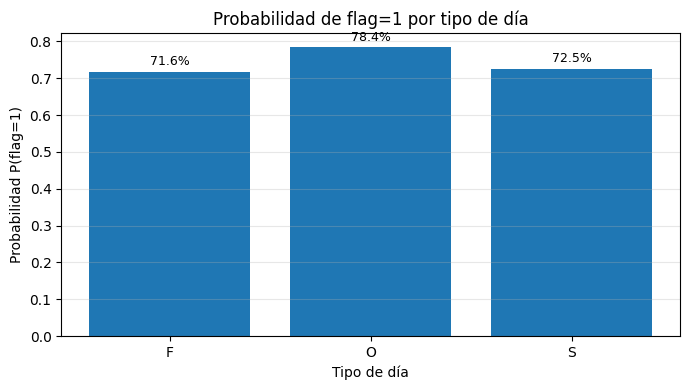

In [42]:
plt.figure(figsize=(7,4))
plt.bar(resumen["day_osf"], resumen["p_flag1"])

plt.ylabel("Probabilidad P(flag=1)")
plt.xlabel("Tipo de día")
plt.title("Probabilidad de flag=1 por tipo de día")
plt.grid(True, axis="y", alpha=0.3)

# Etiquetas con %
for i, row in resumen.iterrows():
    plt.text(
        x=row["day_osf"],
        y=row["p_flag1"] + 0.01,
        s=f'{row["p_flag1"]*100:.1f}%',
        ha="center",
        va="bottom",
        fontsize=9
    )

plt.tight_layout()
plt.show()


### Barras de conteo (n) por day_osf

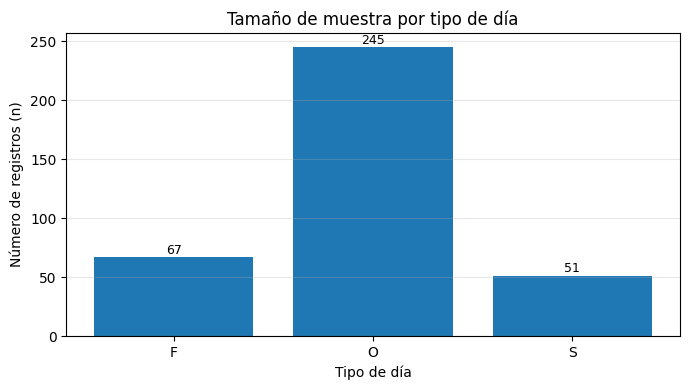

In [43]:
plt.figure(figsize=(7,4))
plt.bar(resumen["day_osf"], resumen["n"])

plt.ylabel("Número de registros (n)")
plt.xlabel("Tipo de día")
plt.title("Tamaño de muestra por tipo de día")
plt.grid(True, axis="y", alpha=0.3)

for i, row in resumen.iterrows():
    plt.text(
        x=row["day_osf"],
        y=row["n"] + 0.5,
        s=str(int(row["n"])),
        ha="center",
        va="bottom",
        fontsize=9
    )

plt.tight_layout()
plt.show()


### Probabilidad con intervalo de confianza (error bars)

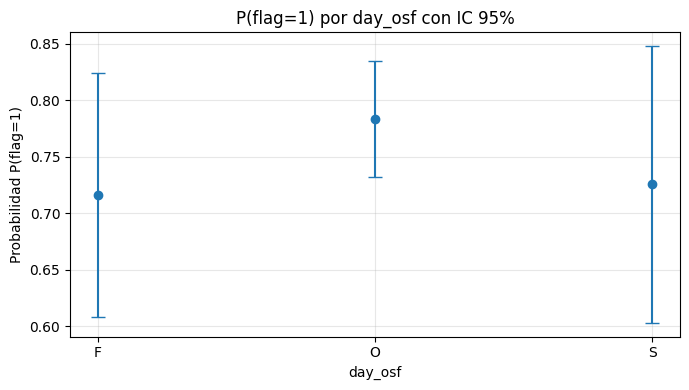

In [44]:
plt.figure(figsize=(7,4))

y = resumen["p_flag1"].values
yerr = np.vstack([
    y - resumen["ci95_low"].values,
    resumen["ci95_high"].values - y
])

plt.errorbar(
    resumen["day_osf"], y,
    yerr=yerr,
    fmt="o",
    capsize=5
)

plt.ylabel("Probabilidad P(flag=1)")
plt.xlabel("day_osf")
plt.title("P(flag=1) por day_osf con IC 95%")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### Heatmap simple de frecuencias (day_osf vs flag)

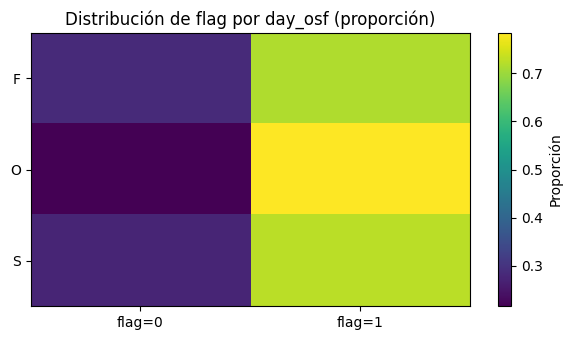

flag,0,1
day_osf,,
F,0.283582,0.716418
O,0.216327,0.783673
S,0.274510,0.725490


In [45]:
tabla = pd.crosstab(df["day_osf"], df["flag"], normalize="index")  # proporciones por day_osf
tabla = tabla.reindex(columns=sorted(tabla.columns))              # orden 0,1 si aplica

plt.figure(figsize=(6,3.5))
plt.imshow(tabla.values, aspect="auto")

plt.xticks(range(len(tabla.columns)), [f"flag={c}" for c in tabla.columns])
plt.yticks(range(len(tabla.index)), tabla.index)

plt.title("Distribución de flag por day_osf (proporción)")
plt.colorbar(label="Proporción")
plt.tight_layout()
plt.show()

tabla
